# how many empty scenes?
# how many objects with only one or two points?

In [1]:
from time import time
from typing import Sequence
import matplotlib.pyplot as plt
import numpy as np    
from radar_scenes.coordinate_transformation import *
from radar_scenes.sequence import Sequence
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

In [2]:
def get_timestamps(sequence: Sequence):
    '''
    Create the list of all timesteps
    '''
    timestamps = []
    for idx, scene in enumerate(sequence.scenes()):
        radar_data = scene.radar_data
        timestamps.append(radar_data[0][0]) 
    return timestamps
        

def get_current_scenes(sequence: Sequence, cur_idx, timestamps, n_prev_frames:int, n_next_frames: int): # what is timestamps?? 
    """
    Retrieves the scenes which should be displayed according to the current values of the time slider and the
    spinboxes for the past and future frames.
    Values of the spinboxes are retrieved and from the list of timestamps, the corresponding times are obtained.
    :return: The current frame (type Scene) and a list of other frames (type Scene) which should be displayed.
    """
    # cur_idx = timeline_slider.value()
    cur_timestamp = timestamps[cur_idx]
    current_scene = sequence.get_scene(cur_timestamp)
    other_scenes = []
    for i in range(1, n_prev_frames + 1):  # in the GUI, show previous frames/ show future frames!
        if cur_idx - i < 0:
            break
        t = timestamps[cur_idx - i]
        other_scenes.append(sequence.get_scene(t))
    for i in range(1, n_next_frames + 1):
        if cur_idx + i >= len(timestamps):
            break
        t = timestamps[cur_idx + i]
        other_scenes.append(sequence.get_scene(t))
    return current_scene, other_scenes


def trafo_radar_data_world_to_car(scene, other_scenes) -> np.ndarray:
    """
    Transforms the radar data listed in other_scenes into the same car coordinate system that is used in 'scene'.
    :param scene: Scene. Containing radar data and odometry information of one scene. The odometry information from
    this scene is used to transform the detections from the other timestamps into this scene.
    :param other_scenes: List of Scene items. All detections in these other scenes are transformed
    :return: A numpy array with all radar data from all scenes. The fields "x_cc" and "y_cc" are now relative to the
    current scene.
    """
    if len(other_scenes) == 0:
        return scene.radar_data
    other_radar_data = np.hstack([x.radar_data for x in other_scenes])
    x_cc, y_cc = transform_detections_sequence_to_car(other_radar_data["x_seq"], other_radar_data["y_seq"],
                                                        scene.odometry_data)
    other_radar_data["x_cc"] = x_cc
    other_radar_data["y_cc"] = y_cc
    return np.hstack([scene.radar_data, other_radar_data])


def get_frames(sequence: Sequence, cur_idx, timestamps, n_prev_frames=0 , n_next_frames=0):
    """
    Plot the current frames.
    :param: cur_idx: the frame number to be ploted
    :return: None
    """
    if len(timestamps) == 0 or cur_idx >= len(timestamps):
        return
    cur_timestamp = timestamps[cur_idx]
    current_scene, other_scenes = get_current_scenes(sequence, cur_idx, timestamps, n_prev_frames, n_next_frames)   # 4 sensors together
    radar_data = trafo_radar_data_world_to_car(current_scene, other_scenes) 
    return radar_data

def plot_frames(radar_data: list):
    # extract x, y from the list
    x = np.zeros(len(radar_data))
    y = np.zeros(len(radar_data))
    for idx, point in enumerate(radar_data): # radar_data is ndarray already, can be simplified here !
        x[idx] = point[7]
        y[idx] = point[8]
    col = [0, 0, 0, 1]
    plt.plot(
        y,
        x,
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=3
    )
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().invert_xaxis()
    plt.show()
    return

# statistic for the whole dataset

In [3]:

path_to_dataset = "/home/s0001516/thesis/dataset/data"
# list all the folders
list_sequences = os.listdir(path_to_dataset)
nm_labeled_points = []
nm_instances = []
# iterate over all sequences
nm = 0
for nm_sequence in list_sequences:
    path_sequence = os.path.join(path_to_dataset, nm_sequence)
    if os.path.isdir(path_sequence):
        # Define the *.json file from which data should be loaded
        filename = os.path.join(path_sequence, "scenes.json")
        sequence = Sequence.from_json(filename)
        timestamps = get_timestamps(sequence)
        # iterate over all sensor scans
        for cur_idx in range(len(timestamps)):
            #m number of labeled points (not background)
            radar_data = get_frames(sequence, cur_idx, timestamps)
            labeled_idx = np.where(radar_data["label_id"] != 11)[0] # not static # 11 means static points, background
            idx = radar_data.shape[0]
            nm += idx
            nm_labeled_points.append(len(labeled_idx))
            # number of instances
            track_ids = set(radar_data["track_id"])
            nm_instances.append(len(track_ids)-1)

print('Number of total sensor scans is {}'.format(len(nm_labeled_points)))
print('Number of total points is {}'.format(nm))

In [ ]:
print('Number of total points is {}'.format(len(nm_labeled_points)))
#print(nm_labeled_points)
print(len(track_ids))  # total number of unique objects

# Task 1: replot the histogram as Fig 4b

In [ ]:
# plot histogram

"""
"""
plt.hist(np.array(nm_labeled_points), bins=np.arange(1, 50, 5), facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("number of labeled points", fontsize=15)
# 显示纵轴标签
plt.ylabel("frequency", fontsize=15)
# 显示图标题
plt.title("labled points per scan", fontsize=15)
plt.show()

how many sensor scan that has no labeled points?

In [ ]:
a = sum(np.array(nm_labeled_points)==0)
b = sum(np.array(nm_labeled_points)==1)
print('There are {} / {} scan with no labeled points \n {}'.format(a, len(nm_labeled_points), a/len(nm_labeled_points)))
print('There are {} / {} scan with one labeled points \n {}'.format(b, len(nm_labeled_points), b/len(nm_labeled_points)))

In [ ]:
print('There are {} / {} scan with no labeled points or with only one labelled points \n {}'.format(a+b, len(nm_labeled_points), (a+b)/len(nm_labeled_points)))

Looks quite close to 4 b)

In [ ]:
# 
y1 = sum(np.array(nm_instances) == 1)
y2 = sum(np.array(nm_instances) == 2)
y3 = sum(np.array(nm_instances) == 3)
y4 = sum(np.array(nm_instances) == 4)
print(y1)
print(y2)
print(y3)
print(y4)
x = range(1, np.max(nm_instances))
y = []
for i in x:
    y.append(sum(np.array(nm_instances) == i))

In [ ]:

plt.bar(x, y)
# 显示横轴标签
plt.xlabel("number of instances", fontsize=15)
# 显示纵轴标签
plt.ylabel("frequency", fontsize=15)
# 显示图标题
plt.title("instances per scan", fontsize=15)
plt.show()


In [ ]:
print(sum(y)) # totoal number of instances

In [ ]:
print(np.array([radar_data['x_cc'], radar_data['y_cc']]).shape)

# How many frames does a 500ms-snippet contain?

In [ ]:
# time interval distribution

path_to_dataset = "/home/s0001516/thesis/dataset/data"
# list all the folders
list_sequences = os.listdir(path_to_dataset)
intervals = []
# iterate over all sequences
for nm_sequence in list_sequences:
    path_sequence = os.path.join(path_to_dataset, nm_sequence)
    if os.path.isdir(path_sequence):
        # Define the *.json file from which data should be loaded
        filename = os.path.join(path_sequence, "scenes.json")
        sequence = Sequence.from_json(filename)
        timestamps = get_timestamps(sequence)
        intervals += list(np.array(timestamps[1:-1])-np.array(timestamps[0:-2])) 

In [ ]:
plt.hist(np.array(intervals), bins=np.arange(1, 100000, 1000), facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("time interval/us", fontsize=15)
# 显示纵轴标签
plt.ylabel("frequency", fontsize=15)
# 显示图标题
plt.title("frequency of time interval", fontsize=15)
plt.show()

In [ ]:
print("maximum time interval {}".format(max(intervals)))
print("minimum time interval {}".format(min(intervals)))
print("median time interval {}".format(np.median(intervals)))
counts = np.bincount(intervals)
print("most frequent time interval {}".format(np.argmax(counts)))


In [ ]:
# non overlapping

path_to_dataset = "/home/s0001516/thesis/dataset/data"
# list all the folders
list_sequences = os.listdir(path_to_dataset)
counts = []
# iterate over all sequences
for nm_sequence in list_sequences:
    path_sequence = os.path.join(path_to_dataset, nm_sequence)
    if os.path.isdir(path_sequence):
        # Define the *.json file from which data should be loaded
        filename = os.path.join(path_sequence, "scenes.json")
        sequence = Sequence.from_json(filename)
        timestamps = get_timestamps(sequence)
        intervals = list(np.array(timestamps[1:-1])-np.array(timestamps[0:-2])) 
        sum = 0
        count = 0
        for interval in intervals:
            if sum < 500000:
                sum += interval
                count += 1
            else:
                counts.append(count)
                sum = 0
                count = 0


print("maximum number of scans {}".format(max(counts)))
print("minimum number of scans {}".format(min(counts)))
print("median number of scans {}".format(np.median(counts)))
x = np.bincount(counts)
print("most frequent number of scans {}".format(np.argmax(x)))            

# what is the distribution of track-id over time looks like?

In [ ]:
path_to_dataset = "/home/s0001516/thesis/dataset/RadarScenes/data"
# list all the folders
list_sequences = os.listdir(path_to_dataset)
nm_labeled_points = []
nm_instances = []
# iterate over all sequences
for nm_sequence in list_sequences:
    path_sequence = os.path.join(path_to_dataset, nm_sequence)
    if os.path.isdir(path_sequence):
        # Define the *.json file from which data should be loaded
        filename = os.path.join(path_sequence, "scenes.json")
        sequence = Sequence.from_json(filename)
        timestamps = get_timestamps(sequence)
        # iterate over all sensor scans
        for cur_idx in range(len(timestamps)):
            # number of instances
            track_ids = set(radar_data["track_id"])
            for track in track_ids:
                if radar_data["track_id"]:############? use panda!  determine track_id's index, use it to sort time stamp


# Doppler Value Skew and Distribution

In [ ]:
path_to_dataset = "/home/s0001516/thesis/dataset/data"
# list all the folders
list_sequences = os.listdir(path_to_dataset)
vr = np.array([0])
# iterate over all sequences
for nm_sequence in list_sequences:
    path_sequence = os.path.join(path_to_dataset, nm_sequence)
    if os.path.isdir(path_sequence):
        # Define the *.json file from which data should be loaded
        filename = os.path.join(path_sequence, "scenes.json")
        sequence = Sequence.from_json(filename)
        timestamps = get_timestamps(sequence)
        # iterate over all sensor scans
        sampled_idxes = np.random.randint(0, len(timestamps), size=200) #100/7291
        for cur_idx in sampled_idxes:
            # absolute value of radial velocity
            radar_data = get_frames(sequence, cur_idx, timestamps)
            vr = np.hstack((vr, np.abs(radar_data["vr_compensated"])))

vr = np.delete(vr, 0)

In [ ]:
def skew_vr(vr):
    '''
    Using the depicted polynomial scaling function, the distribution is widened 
    in order to ease the feature extraction process

    in fig 7, a fourth order polynomial is used
    '''
    x = np.arange(0, 3.00, 0.25)
    y = np.hstack((np.array([0, 3/4, 15/16, 31/32]), np.linspace(1, 2.75, 8)))
    g = interp1d(x, y, kind="cubic")
    new_vr = 40 * g(vr/40)
    return new_vr     

print(max(vr))
new_vr = skew_vr(vr)
print(max(new_vr))

In [ ]:

m = plt.hist(new_vr, bins=np.arange(0, 100, 0.5), facecolor="red", edgecolor="red", alpha=0.7)
n = plt.hist(vr, bins=np.arange(0, 100, 1), facecolor="blue", edgecolor="blue", alpha=0.7)
plt.xlabel("radia velocity m/s")
plt.ylabel("frequency of radial velocity")
plt.yscale('log')
plt.title("frequency of radial velocity")
plt.legend(['skewed Vr distribution', 'origin distribution'])
plt.show()

# Skew function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
x = np.arange(0, 3.00, 0.25)
y = np.hstack((np.array([0, 3/4, 15/16, 31/32]), np.linspace(1, 2.75, 8)))
g = interpolate.interp1d(x, y, kind="cubic")

f = lambda x : np.sqrt(x)
a = np.arange(0, 2, 0.01)
plt.plot(40*a, 40*f(a), '-')
plt.plot(40*a, 40*g(a), 'r-')
plt.plot(40*a, 40*a, 'g-')

## Nicolas' origin

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def skew_vr_origin(im):
    sx = np.array([0, 10, 20, 27.5, 40])
    sy = np.array([0, 0.7, 0.9, 0.95, 1])
    poly = np.poly1d(np.polyfit(sx, sy, 4))  # degree of freedom
    lin = np.poly1d(np.polyfit(sx[-2:], sy[-2:], 1))

    poly_msk = im < 27.5
    lin_msk = im >= 27.5
    im[poly_msk] = poly(im[poly_msk])
    im[lin_msk] = lin(im[lin_msk])

    im = np.clip(im, a_min=0.0, a_max=1.0, out=im)
    im[np.isclose(im, 0)] = 0
    return 40*im

def skew_vr_int(im):
    sx = np.array([0, 10, 20, 27.5, 40])
    sy = np.array([0, 0.7, 0.9, 0.95, 1])
    poly = np.poly1d(np.polyfit(sx, sy, 4))
    lin = np.poly1d(np.polyfit(sx[-2:], sy[-2:], 1))

    if im < 27.5:
        im = poly(im)
    else:
        im = lin(im)

    # im = np.clip(im, a_min=0.0, a_max=1.0, out=im)
    # im[np.isclose(im, 0)] = 0
    return im

In [ ]:
a = np.arange(0, 2, 0.01)
b =  (40 * a).tolist()

plt.plot(40*a, 40*np.array(list(map(skew_vr_int, b))), 'b-')
#plt.plot(40*a, 40*g(a), 'r-')
plt.plot(40*a, 40*a, 'g--')
plt.xlabel("Original velocity m/s", fontsize=15)
plt.ylabel("Skewed velocity m/s", fontsize=15)
plt.title("Velocity skew function", fontsize=15)
plt.legend(['skew function', '$y=x$'])
plt.show()

In [ ]:
n = plt.hist(vr, bins=np.arange(0, 100, 1), facecolor="blue", edgecolor="blue", alpha=0.7)
new_vr = skew_vr_origin(vr)
m = plt.hist(new_vr, bins=np.arange(0, 100, 0.5), facecolor="red", edgecolor="red", alpha=0.7)
plt.xlabel("radia velocity m/s")
plt.ylabel("frequency of radial velocity")
plt.yscale('log')
plt.title("frequency of radial velocity")
plt.legend(['origin distribution', 'skewed Vr distribution'])
plt.show()

# Are all the scenes from a same sensor uniformly-distributed? 

In [ ]:
path_sequence = "/home/s0001516/thesis/dataset/RadarScenes/train/sequence_17"
intervals = []
if os.path.isdir(path_sequence):
    # Define the *.json file from which data should be loaded
    filename = os.path.join(path_sequence, "scenes.json")
    sequence = Sequence.from_json(filename)
    timestamps = get_timestamps(sequence)
    start_timestamp = sequence.first_timestamp
    print(start_timestamp)
    #print sensor id
    timestamp = sequence.next_timestamp_after(start_timestamp)
    print('sensor id {}'.format( sequence.get_scene(timestamp).sensor_id))
    while timestamp in timestamps:
        next_timestamp = sequence.next_timestamp_after(timestamp, same_sensor=True)
        if next_timestamp == None:
            break
        intervals.append(next_timestamp - timestamp)
        timestamp = next_timestamp
        


In [ ]:

m = plt.hist(intervals, bins=np.arange(0, 1e5, 100), facecolor="red", edgecolor="red", alpha=0.7)
plt.xlabel("time interval for each scan from sensor id 3")
plt.ylabel("frequency")
#plt.yscale('log')
plt.show()

In [ ]:
print(np.median( intervals))
print(np.mean( intervals))
print(np.min(intervals))
print(np.max(intervals))

## Class Distribution

In [5]:
# create a table to store how many objects in each class per sequence
# 158 rows, 5 columns
# use snippet.py to generate data.txt first
from labels import ClassificationLabel
from dataset import BasicDataset
from frame import get_frames, get_timestamps
from numpy import ndarray, zeros, where, savetxt, sum, array
from matplotlib import pyplot as plt


class BalanceDataset(BasicDataset):
    def __init__(self, dataset_path, snip_path):
        super().__init__(dataset_path, snip_path)
        self.table = zeros(158,
                  dtype=[('CAR', 'int'), ('PEDESTRIAN', 'int'), ('PEDESTRIAN_GROUP', 'int'), 
                        ('TWO_WHEELER', 'int'), ('LARGE_VEHICLE', 'int')])

    def count_class(self):
        for line, cur_seq in enumerate(self.list_sequence):
            seq_name = cur_seq.sequence_name
            seq_idx = int(seq_name.split("_")[1])
            timestamps = get_timestamps(cur_seq)
            # iterate over snippet
            list_start_idx = self.list_start_idx[line]
            list_num_frame = self.list_num_future_frames[line]
            for i, start in enumerate(list_start_idx):
                num_frame = list_num_frame[i]
                snip = get_frames(cur_seq, start, 
                            timestamps, n_next_frames=num_frame)
                # iterate over snippets
                track_ids = set(snip["track_id"])
                for tr_id in track_ids:
                    if tr_id != b'':
                        idx = where(snip["track_id"] == tr_id)[0]
                        num_points = len(idx)
                        class_label = snip[idx[0]]['label_id']
                        mapped_class_label = ClassificationLabel.label_to_clabel(class_label).value
                        if mapped_class_label != 5:
                            self.table[line][mapped_class_label] += 1                                           
                            
    def write_table(self):
        #print(self.table)
        savetxt('./table.txt', self.table, fmt='%d')

    def get_histogram(self):
        self.table
        hist = []
        for name in ['CAR', 'PEDESTRIAN', 'PEDESTRIAN_GROUP', 'TWO_WHEELER', 'LARGE_VEHICLE']:
            a = sum(self.table[name])
            print("{}:{}".format(name, a))
            hist.append(a)
        # plot
        x = [1,2,3,4,5]
        x_label=['CAR', 'PEDESTRIAN', 'PEDESTRIAN\n_GROUP', 'TWO\n_WHEELER', 'LARGE\n_VEHICLE']
        plt.xticks(x, x_label)
        plt.bar(x, hist)
        plt.show()        

CAR:47366
PEDESTRIAN:23537
PEDESTRIAN_GROUP:29447
TWO_WHEELER:6872
LARGE_VEHICLE:8753


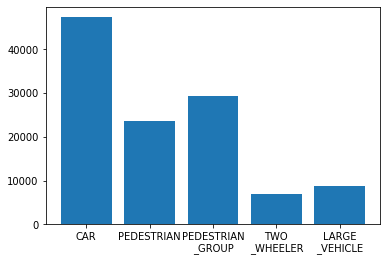

In [6]:
snip_path = 'static/data.txt'
dataset_path = "/home/s0001516/thesis/dataset/data/"
dataset = BalanceDataset(dataset_path, snip_path)
dataset.count_class()
dataset.get_histogram()
dataset.write_table()   

In [ ]:
snip_path = 'static/test0.txt'
dataset_path = "/home/s0001516/thesis/dataset/RadarScenes_GPU/test"
dataset = BalanceDataset(dataset_path, snip_path)
dataset.count_class()
dataset.get_histogram()
dataset.write_table()   

In [ ]:
snip_path = 'static/train_full.txt'
dataset_path = "/home/s0001516/thesis/dataset/RadarScenes_GPU/train_full"
dataset = BalanceDataset(dataset_path, snip_path)
dataset.count_class()
dataset.get_histogram()
dataset.write_table()   

## Statistic Per Class
- what are the mean and variance of point numbers in a cluster of a class?
- what are the mean and variance of RCS in a cluster of a class?

## Count the mean and std of point numbers with Welford's algorithm
https://jonisalonen.com/2013/deriving-welfords-method-for-computing-variance/  
Get the mean, standard deviation of the number of the cluster points for each class

In [ ]:
from labels import ClassificationLabel
from dataset import BasicDataset
from frame import get_frames, get_timestamps
from numpy import ndarray, zeros, where, savetxt, sum, array, sqrt
#from matplotlib import pyplot as plt
from snippet import clip
import numba as nb

class CountDataset(BasicDataset):
    def __init__(self, dataset_path, snip_path):
        super().__init__(dataset_path, snip_path)
        self.table = zeros(5,  # num, mean, std, max, min
                  dtype=[('CAR', 'float'), ('PEDESTRIAN', 'float'), ('PEDESTRIAN_GROUP', 'float'), 
                        ('TWO_WHEELER', 'float'), ('LARGE_VEHICLE', 'float')])
        self.table[4] = (10., 10., 10., 10., 10.)
        self.rcs_table = zeros(5,  # num, mean, std, max, min
            dtype=[('CAR', 'float'), ('PEDESTRIAN', 'float'), ('PEDESTRIAN_GROUP', 'float'), 
                ('TWO_WHEELER', 'float'), ('LARGE_VEHICLE', 'float')])
        self.rcs_table[4] = (10., 10., 10., 10., 10.)
 
    #@nb.njit
    def count_points_class(self):
        for line, cur_seq in enumerate(self.list_sequence):
            timestamps = get_timestamps(cur_seq)
            # iterate over snippet
            list_start_idx = self.list_start_idx[line]
            list_num_frame = self.list_num_future_frames[line]
            for i, start in enumerate(list_start_idx):
                num_frame = list_num_frame[i]
                snip = get_frames(cur_seq, start, 
                            timestamps, n_next_frames=num_frame)
                snip = clip(snip)
                # iterate over clusters
                track_ids = set(snip["track_id"])
                for tr_id in track_ids:
                    if tr_id != b'':
                        idx = where(snip["track_id"] == tr_id)[0]
                        num_points = len(idx) # number of points
                        class_label = snip[idx[0]]['label_id']
                        mapped_class_label = ClassificationLabel.label_to_clabel(class_label).value
                        if mapped_class_label != 5:
                            # get max/min num points
                            max_point = self.table[3][mapped_class_label]
                            min_point = self.table[4][mapped_class_label]
                            if max_point < num_points:
                                self.table[3][mapped_class_label] = num_points
                            if min_point > num_points:
                                self.table[4][mapped_class_label] = num_points
                            # get number of instances
                            self.table[0][mapped_class_label] += 1
                            k = self.table[0][mapped_class_label]
                            # get mean and std
                            mean = self.table[1][mapped_class_label]
                            std = self.table[2][mapped_class_label]
                            old_mean = mean
                            mean = mean + (num_points-mean)/k
                            std = std + (num_points-mean)*(num_points-old_mean)
                            self.table[1][mapped_class_label] = mean
                            self.table[2][mapped_class_label] = std
    #@nb.njit
    def count_rcs_class(self):
        for line, cur_seq in enumerate(self.list_sequence):
            timestamps = get_timestamps(cur_seq)
            # iterate over snippet
            list_start_idx = self.list_start_idx[line]
            list_num_frame = self.list_num_future_frames[line]
            for i, start in enumerate(list_start_idx):
                num_frame = list_num_frame[i]
                snip = get_frames(cur_seq, start, 
                            timestamps, n_next_frames=num_frame)
                snip = clip(snip)
                # iterate over clusters
                track_ids = set(snip["track_id"])
                for tr_id in track_ids:
                    if tr_id != b'':
                        idx = where(snip["track_id"] == tr_id)[0]
                        #num_points = len(idx) # number of points
                        class_label = snip[idx[0]]['label_id']
                        mapped_class_label = ClassificationLabel.label_to_clabel(class_label).value
                        if mapped_class_label != 5:
                            for i in idx:
                                max_rcs = self.rcs_table[3][mapped_class_label]
                                min_rcs = self.rcs_table[4][mapped_class_label]
                                mean_rcs = self.rcs_table[1][mapped_class_label]
                                std_rcs = self.rcs_table[2][mapped_class_label]
                                rcs = snip[i]['rcs']
                                if max_rcs < rcs:
                                    self.rcs_table[3][mapped_class_label] = rcs
                                if min_rcs > rcs:
                                    self.rcs_table[4][mapped_class_label] = rcs
                                # get number of points
                                self.rcs_table[0][mapped_class_label] += 1 
                                k = self.rcs_table[0][mapped_class_label]
                                old_mean_rcs = mean_rcs
                                mean_rcs = mean_rcs + (rcs-mean_rcs)/k
                                std_rcs = std_rcs + (rcs-mean_rcs)*(rcs-old_mean_rcs)
                                self.rcs_table[1][mapped_class_label] = mean_rcs
                                self.rcs_table[2][mapped_class_label] = std_rcs

    def get_status(self):
        print('************number of ponits*************')
        print('CAR', 'PEDESTRIAN', 'PEDESTRIAN_GROUP', 'TWO_WHEELER', 'LARGE_VEHICLE')
        print('max', self.table[3])
        print('min', self.table[4])
        print('mean', self.table[1])
        a = self.table.view((float, len(self.table.dtype.names)))
        print('standard deviation', sqrt(a[2]/(a[0]-1)))
        print('************RCS*************')
        print('max', self.rcs_table[3])
        print('min', self.rcs_table[4])
        print('mean', self.rcs_table[1])
        a = self.rcs_table.view((float, len(self.rcs_table.dtype.names)))
        print('standard deviation', sqrt(a[2]/(a[0]-1)))

In [ ]:
snip_path = 'static/train_full.txt'
dataset_path = "/home/s0001516/thesis/dataset/RadarScenes_GPU/train_full"
dataset = CountDataset(dataset_path, snip_path)
dataset.count_points_class()
dataset.count_rcs_class()
dataset.get_status()

************number of ponits*************
CAR PEDESTRIAN PEDESTRIAN_GROUP TWO_WHEELER LARGE_VEHICLE
max (295., 75., 213., 117., 680.)
min (3., 3., 3., 3., 3.)
mean (37.56819363, 16.49654944, 30.80123402, 28.27210584, 97.48299792)
standard deviation [33.16101831  9.34551214 22.74881082 16.70445649 87.8985989 ]
************RCS*************
max (44.6083374, 28.58427811, 35.9949646, 37.66812134, 49.97909546)
min (-30.59911728, -30.59527206, -30.59353256, -30.56733513, -30.58673286)
mean (-3.87777476, -8.35410227, -7.07877276, -10.30983934, 0.05502177)
standard deviation [11.3356935   6.77332734  6.71474572  7.15346528 10.51745426]


In [ ]:
from labels import ClassificationLabel
from dataset import BasicDataset
from frame import get_frames, get_timestamps
from numpy import ndarray, zeros, where, savetxt, sum, array, sqrt
#from matplotlib import pyplot as plt
from snippet import clip
import numba as nb

class StaticDataset(BasicDataset): 
    #@nb.njit
    def count_static_class(self):
        sum_static_vr = 0
        sum_num_static = 0
        max_vr = 0
        for line, cur_seq in enumerate(self.list_sequence):
            timestamps = get_timestamps(cur_seq)
            # iterate over snippet
            list_start_idx = self.list_start_idx[line]
            list_num_frame = self.list_num_future_frames[line]
            for i, start in enumerate(list_start_idx):
                num_frame = list_num_frame[i]
                snip = get_frames(cur_seq, start, 
                            timestamps, n_next_frames=num_frame)
                snip = clip(snip)
                static_id = where(snip['label_id'] == 11)[0]
                static_vr = snip[static_id]['vr_compensated']
                num_static = len(static_id)
                biggest_vr = max(static_vr)
                if biggest_vr > max_vr:
                    max_vr = biggest_vr
                sum_static_vr += sum(static_vr)
                sum_num_static += sum(num_static)
        mean_static_vr = sum_static_vr / sum_num_static    
        print('average vr for static points:', mean_static_vr)
        print('max vr for static points:', max_vr)


snip_path = 'static/train_full.txt'
dataset_path = "/home/s0001516/thesis/dataset/RadarScenes_GPU/train_full"
dataset = StaticDataset(dataset_path, snip_path)
dataset.count_static_class()

average vr for static points: 0.16146290864516225
max vr for static points: 114.888985
